# ASR Assignment 2024-25

This notebook has been provided as a template to get you started on the assignment.  Feel free to use it for your development, or do your development directly in Python.

You can find a full description of the assignment [here](https://www.inf.ed.ac.uk/teaching/courses/asr/coursework-2025.html).

You are provided with two Python modules `observation_model.py` and `wer.py`.  The first was described in [Lab 3](https://github.com/yiwang454/asr_labs/blob/main/asr_lab3_4.ipynb).  The second can be used to compute the number of substitution, deletion and insertion errors between ASR output and a reference text.

It can be used as follows:

```python
import wer

my_refence = 'A B C'
my_output = 'A C C D'

wer.compute_alignment_errors(my_reference, my_output)
```

This produces a tuple $(s,d,i)$ giving counts of substitution,
deletion and insertion errors respectively - in this example (1, 0, 1).  The function accepts either two strings, as in the example above, or two lists.  Matching is case sensitive.

## Template code

Assuming that you have already made a function to generate an WFST, `create_wfst()` and a decoder class, `MyViterbiDecoder`, you can perform recognition on all the audio files as follows:


In [1]:
import glob
import os
import wer
import observation_model
import openfst_python as fst
import math
import time
from collections import Counter
import heapq
from collections import deque

# ... (add your code to create WFSTs and Viterbi Decoder)

In [2]:
class MyViterbiDecoder:
    
    NLL_ZERO = 1e10  # define a constant representing -log(0).  This is really infinite, but approximate
                     # it here with a very large number
    BEAM_WIDTH = 80
    
    MIN_SURVIVAL = 1
    
    IS_PRUNING = True
    
    temp_phones = []
    
#     BEST_PROB = 0
    
    def __init__(self, f, audio_file_name):
        """Set up the decoder class with an audio file and WFST f
        """
        self.om = observation_model.ObservationModel()
        self.f = f
        
        if audio_file_name:
            self.om.load_audio(audio_file_name)
        else:
            self.om.load_dummy_audio()
        
        self.initialise_decoding()

        
    def initialise_decoding(self):
        """set up the values for V_j(0) (as negative log-likelihoods)
        
        """
        
        self.V = []   # stores likelihood along best path reaching state j
        self.B = []   # stores identity of best previous state reaching state j
        self.W = []   # stores output labels sequence along arc reaching j - this removes need for 
                      # extra code to read the output sequence along the best path
        
        for t in range(self.om.observation_length()+1):
            self.V.append([self.NLL_ZERO]*self.f.num_states())
            self.B.append([-1]*self.f.num_states())
            self.W.append([[] for i in range(self.f.num_states())])  #  multiplying the empty list doesn't make multiple
        
        # The above code means that self.V[t][j] for t = 0, ... T gives the Viterbi cost
        # of state j, time t (in negative log-likelihood form)
        # Initialising the costs to NLL_ZERO effectively means zero probability    
        
        # give the WFST start state a probability of 1.0   (NLL = 0.0)
        self.V[0][self.f.start()] = 0.0
        
        # some WFSTs might have arcs with epsilon on the input (you might have already created 
        # examples of these in earlier labs) these correspond to non-emitting states, 
        # which means that we need to process them without stepping forward in time.  
        # Don't worry too much about this!  
        self.traverse_epsilon_arcs(0)        
        
    def traverse_epsilon_arcs(self, t):
        """Traverse arcs with <eps> on the input at time t
        
        These correspond to transitions that don't emit an observation
        
        We've implemented this function for you as it's slightly trickier than
        the normal case.  You might like to look at it to see what's going on, but
        don't worry if you can't fully follow it.
        
        """
        
        states_to_traverse = list(self.f.states()) # traverse all states
        while states_to_traverse:
            
            # Set i to the ID of the current state, the first 
            # item in the list (and remove it from the list)
            i = states_to_traverse.pop(0)   
        
            # don't bother traversing states which have zero probability
            if self.V[t][i] == self.NLL_ZERO:
                    continue
        
            for arc in self.f.arcs(i):
                
                if arc.ilabel == 0:     # if <eps> transition
                  
                    j = arc.nextstate   # ID of next state  
                
                    if self.V[t][j] > self.V[t][i] + float(arc.weight):
                        
                        # this means we've found a lower-cost path to
                        # state j at time t.  We might need to add it
                        # back to the processing queue.
                        self.V[t][j] = self.V[t][i] + float(arc.weight)
                        
                        # save backtrace information.  In the case of an epsilon transition, 
                        # we save the identity of the best state at t-1.  This means we may not
                        # be able to fully recover the best path, but to do otherwise would
                        # require a more complicated way of storing backtrace information
                        self.B[t][j] = self.B[t][i] 
                        
                        # and save the output labels encountered - this is a list, because
                        # there could be multiple output labels (in the case of <eps> arcs)
                        if arc.olabel != 0:
                            self.W[t][j] = self.W[t][i] + [arc.olabel]
                        else:
                            self.W[t][j] = self.W[t][i]
                        
                        if j not in states_to_traverse:
                            states_to_traverse.append(j)

    
#     def forward_step(self, t):
          
#         for i in self.f.states():
            
#             if not self.V[t-1][i] == self.NLL_ZERO:   # no point in propagating states with zero probability
                
#                 #if self.V[t-1][i] >= self.PRUNE_THRESHOLD * self.BEST_PROB:

#                 for arc in self.f.arcs(i):

#                     if arc.ilabel != 0: # <eps> transitions don't emit an observation
#                         j = arc.nextstate
#                         tp = float(arc.weight)  # transition prob
#                         ep = -self.om.log_observation_probability(self.f.input_symbols().find(arc.ilabel), t)  # emission negative log prob
#                         prob = tp + ep + self.V[t-1][i] # they're logs
#                         if prob < self.V[t][j]:
#                             #self.BEST_PROB = prob #does this need to be state specific?
#                             self.V[t][j] = prob
#                             self.B[t][j] = i

#                             # store the output labels encountered too
#                             if arc.olabel !=0:
#                                 self.W[t][j] = [arc.olabel]
#                             else:
#                                 self.W[t][j] = []
        
    def forward_step(self, t):
        active_states = [(self.V[t-1][i], i) for i in self.f.states() if self.V[t-1][i] != self.NLL_ZERO]
        heapq.heapify(active_states)  # Process states in increasing cost order

        obs_cache = {}  # Cache for observation probabilities

        while active_states:
            _, i = heapq.heappop(active_states)  # Get lowest-cost state

            for arc in self.f.arcs(i):
                if arc.ilabel != 0:  # Skip epsilon arcs
                    j = arc.nextstate
                    tp = float(arc.weight)  # Transition probability

                    # Cache observation probability
                    if arc.ilabel not in obs_cache:
                        obs_cache[arc.ilabel] = -self.om.log_observation_probability(self.f.input_symbols().find(arc.ilabel), t)

                    ep = obs_cache[arc.ilabel]
                    prob = tp + ep + self.V[t-1][i]

                    if prob < self.V[t][j]:
                        self.V[t][j] = prob
                        self.B[t][j] = i

                        if arc.olabel != 0:
                            self.W[t][j] = [arc.olabel]
                        else:
                            self.W[t][j] = []                        
        
        
    def finalise_decoding(self):
            """ this incorporates the probability of terminating at each state
            """

            best_final_cost = self.NLL_ZERO
            best_final_state = -1

            for state in self.f.states():
                final_weight = float(self.f.final(state))

                if self.V[-1][state] != self.NLL_ZERO:
                    if final_weight != math.inf:
                        self.V[-1][state] += final_weight

                    # Track the best final state
                    if self.V[-1][state] < best_final_cost:
                        best_final_cost = self.V[-1][state]
                        best_final_state = state

            # Fallback: if no final state was reached, use the best available path
            if best_final_state == -1:
                # Pick the lowest-cost path even if it doesn't end at a final state
                best_final_state = min(
                    range(len(self.V[-1])), key=lambda x: self.V[-1][x]
                )

            # Handle case where no path made it to the end
            if self.V[-1][best_final_state] >= self.NLL_ZERO:
                print("No path reached a valid final state. Using best available path.")
        
        
    def decode(self, bigrams):
        start = time.perf_counter()
        self.initialise_decoding()
        t = 1
        while t <= self.om.observation_length():
            self.forward_step(t)
            self.traverse_epsilon_arcs(t)
            if self.IS_PRUNING:
                self.pruning(t) #comment out if you want to stop pruning
            t += 1
        self.finalise_decoding()
        
        end = time.perf_counter()
        elapsed = end - start
        
        return t, elapsed
    
#     #prune function which takes in T and checks the current self.V[t]
#     def pruning(self, t):
#         current_V = self.V[t] #get the list of states at this timestate
#         min_V = min(current_V)
#         if min_V == self.NLL_ZERO: #dont prune yet if the minimum V is infinite bc it means the V hasnt been populated
#             return
#         beam_thresh = min_V + self.BEAM_WIDTH
#         for j in self.f.states():
#             if current_V[j] > beam_thresh:
#                 self.V[t][j] = self.NLL_ZERO #set the current time and state vitrbi to be huge so the path is unlikely
    
    def pruning(self, t):
        current_V = self.V[t]
        min_V = min(current_V)

        if min_V == self.NLL_ZERO:  # Avoid pruning if no state is populated
            return

        best_V = min(v for v in current_V if v != self.NLL_ZERO)  # Get best probability
        beam_thresh = best_V + self.BEAM_WIDTH  # Prune based on best, not min

        for j in self.f.states():
            if current_V[j] > beam_thresh:
                self.V[t][j] = self.NLL_ZERO  # Remove unlikely paths
    
    def backtrace(self):
        start = time.perf_counter()
        
        best_final_state = self.V[-1].index(min(self.V[-1])) # argmin
        best_state_sequence = [best_final_state]
        best_out_sequence = []
        
        t = self.om.observation_length()   # ie T
        j = best_final_state
        
        while t >= 0:
            i = self.B[t][j]
            best_state_sequence.append(i)
            best_out_sequence = self.W[t][j] + best_out_sequence  # computer scientists might like
                                                                                # to make this more efficient!

            # continue the backtrace at state i, time t-1
            j = i  
            t-=1
            
        best_state_sequence.reverse()
        
        # convert the best output sequence from FST integer labels into strings
        best_out_sequence = ' '.join([self.f.output_symbols().find(label) for label in best_out_sequence])
        #convert out_sequence to words from the phonesdef convert_phones_to_words(phone_sequence, phone_to_word):
        temp_phones = []
        word_sequence = []
        
        for phone in best_out_sequence.split(" "):
            temp_phones.append(phone)
            
            for word, phones in lex.items():
                if phones == temp_phones:
                    if word != "<sil>":
                        word_sequence.append(word)
                    temp_phones.clear()
        word_sequence = " ".join(word_sequence)
        
        end = time.perf_counter()
        elapsed = end - start
        
        return (best_state_sequence, word_sequence, elapsed)

In [3]:
def parse_lexicon(lex_file):
    """
    Parse the lexicon file and return it in dictionary form.
    
    Args:
        lex_file (str): filename of lexicon file with structure '<word> <phone1> <phone2>...'
                        eg. peppers p eh p er z

    Returns:
        lex (dict): dictionary mapping words to list of phones
    """
    
    lex = {}  # create a dictionary for the lexicon entries (this could be a problem with larger lexica)
    with open(lex_file, 'r') as f:
        for line in f:
            line = line.split()  # split at each space
            lex[line[0]] = line[1:]  # first field the word, the rest is the phones
    lex["<sil>"] = ["sil"]
    return lex

def generate_symbol_tables(lexicon, n=3):
    '''
    Return word, phone and state symbol tables based on the supplied lexicon
        
    Args:
        lexicon (dict): lexicon to use, created from the parse_lexicon() function
        n (int): number of states for each phone HMM
        
    Returns:
        word_table (fst.SymbolTable): table of words
        phone_table (fst.SymbolTable): table of phones
        state_table (fst.SymbolTable): table of HMM phone-state IDs
    '''
    
    state_table = fst.SymbolTable()
    phone_table = fst.SymbolTable()
    word_table = fst.SymbolTable()
    
    # add empty <eps> symbol to all tables
    state_table.add_symbol('<eps>')
    phone_table.add_symbol('<eps>')
    word_table.add_symbol('<eps>')
    
    for word, phones  in lexicon.items():
        
        word_table.add_symbol(word)
        
        for p in phones: # for each phone
            
            phone_table.add_symbol(p)
            for i in range(1,n+1): # for each state 1 to n
                state_table.add_symbol('{}_{}'.format(p, i))
            
    return word_table, phone_table, state_table


# call these two functions
lex = parse_lexicon('lexicon.txt')
word_table, phone_table, state_table = generate_symbol_tables(lex)
# state_table.write_text('tmp.txt')
# print(open('tmp.txt').read())

def generate_phone_wfst(f, start_state, phone, n):
    """
    Generate a WFST representating an n-state left-to-right phone HMM
    
    Args:
        f (fst.Fst()): an FST object, assumed to exist already
        start_state (int): the index of the first state, assmed to exist already
        phone (str): the phone label 
        n (int): number of states for each phone HMMectly modified i
        
    Returns:
        the final state of the FST
    """
    
    current_state = start_state
    
    for i in range(1, n+1):
        
        in_label = state_table.find('{}_{}'.format(phone, i))
        
        sl_weight = fst.Weight('log', -math.log(0.9))  # weight for self-loop
        # self-loop back to current state
        f.add_arc(current_state, fst.Arc(in_label, 0, sl_weight, current_state))
        
        # transition to next state
        
        # we want to output the phone label on the final state
        # note: if outputting words instead this code should be modified
        if i == n:
            out_label = phone_table.find(phone)
        else:
            out_label = 0   # output empty <eps> label
            
        next_state = f.add_state()
        next_weight = fst.Weight('log', -math.log(0.1)) # weight to next state
        f.add_arc(current_state, fst.Arc(in_label, out_label, next_weight, next_state))    
       
        current_state = next_state
        
    return current_state

In [4]:
# Load words from lexicon
word_list = []
with open("lexicon.txt", "r") as lexicon:
    for line in lexicon:
        word = line.split()[0].lower()  # Extract only the first word
        word_list.append(word)

# Count word occurrences
word_counts = Counter(word_list)

# Total number of words
total_words = sum(word_counts.values())

# Compute unigram probabilities
word_probs = {word: count / total_words for word, count in word_counts.items()}

# Print top words
# for word, prob in sorted(word_probs.items(), key=lambda x: x[1], reverse=True):
#     print(f"{word}: {prob:.5f}")

In [5]:
def read_transcription(wav_file):
    """
    Get the transcription corresponding to wav_file.
    """
    
    transcription_file = os.path.splitext(wav_file)[0] + '.txt'
    
    with open(transcription_file, 'r') as f:
        transcription = f.readline().strip()
    
    return transcription

all_transcription = []

for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'): 
    ts = read_transcription(wav_file)
    all_transcription.append(ts)
    
#print(all_transcription)    


def build_bigram_model_backoff(corpus):
    bigram_model = {}
    unigram_counts = Counter()
    
    for sentence in corpus:
        words = sentence.split()
        for word in words:
            unigram_counts[word] += 1
        for i in range(len(words) - 1):
            if words[i] not in bigram_model:
                bigram_model[words[i]] = Counter()
            bigram_model[words[i]][words[i+1]] += 1
    
    total_unigrams = sum(unigram_counts.values())
    unigram_probs = {word: count / total_unigrams for word, count in unigram_counts.items()}
    
    # Convert counts to probabilities with backoff
    for word, following in bigram_model.items():
        total_count = sum(following.values())
        prob_dist = {}

        for next_word, count in following.items():
            prob_dist[next_word] = (count / total_count) * 0.95
            prob_dist["<sil>"] = 1/11 * 0.95
        # Backoff to unigram probability scaled by 0.05
        for next_word, prob in unigram_probs.items():
            if next_word not in prob_dist:
                prob_dist[next_word] = prob * 0.05

        # Normalize the probabilities to sum to 1
        total_prob = sum(prob_dist.values())
        bigram_model[word] = {k: v / total_prob for k, v in prob_dist.items()}

    # Adding silence transition probabilities
    words = list(bigram_model.keys())
    silence_prob = 1 / (len(words) + 1)  # +1 for <sil>
    bigram_model["<sil>"] = {word: silence_prob for word in words}
    bigram_model["<sil>"]["<sil>"] = silence_prob

    return bigram_model


def verify_probabilities(bigram_model):
    for word, transitions in bigram_model.items():
        total_prob = sum(transitions.values())
        if not (0.999 <= total_prob <= 1.001):  # Allowing small floating-point errors
            print(f"Warning: Probabilities for '{word}' sum to {total_prob}, not 1")
        else:
            print(f"'{word}' probabilities sum correctly to {total_prob}")


bigrams = build_bigram_model_backoff(all_transcription)
verify_probabilities(bigrams)
print(bigrams["a"].keys())

'peter' probabilities sum correctly to 1.0
'piper' probabilities sum correctly to 1.0000000000000002
'pickled' probabilities sum correctly to 1.0000000000000004
'a' probabilities sum correctly to 0.9999999999999998
'peck' probabilities sum correctly to 0.9999999999999997
'of' probabilities sum correctly to 1.0000000000000002
'picked' probabilities sum correctly to 1.0
'the' probabilities sum correctly to 1.0000000000000004
'peppers' probabilities sum correctly to 1.0
'where's' probabilities sum correctly to 1.0
'<sil>' probabilities sum correctly to 1.0000000000000002
dict_keys(['peck', '<sil>', 'pickled', 'the', 'peter', "where's", 'of', 'piper', 'a', 'picked', 'peppers'])


In [6]:
# def build_bigram_model(corpus):
#     bigram_model = {}
    
#     #bigrams store P(X | Y) as Y:{X:0.5, Z:0.5}
    
#     for sentence in corpus:
#         words = sentence.split()
#         for i in range(len(words) - 1):
#             if words[i] not in bigram_model:
#                 bigram_model[words[i]] = Counter()
#             bigram_model[words[i]][words[i+1]] += 1
    
#     # Convert counts to probabilities
#     for word, following in bigram_model.items():
#         total_count = sum(following.values())
#         bigram_model[word] = {next_word: -math.log((count / total_count)*(10/11)) for next_word, count in following.items()}
#         bigram_model[word].update({"<sil>": -math.log(1/11)})
    
#     #instead of making a silence dictionary within bigram, we use the last actual word to inform the weight of the next arc
#     #this doesnt work for moving to silence as we need to have a probability
#     return bigram_model

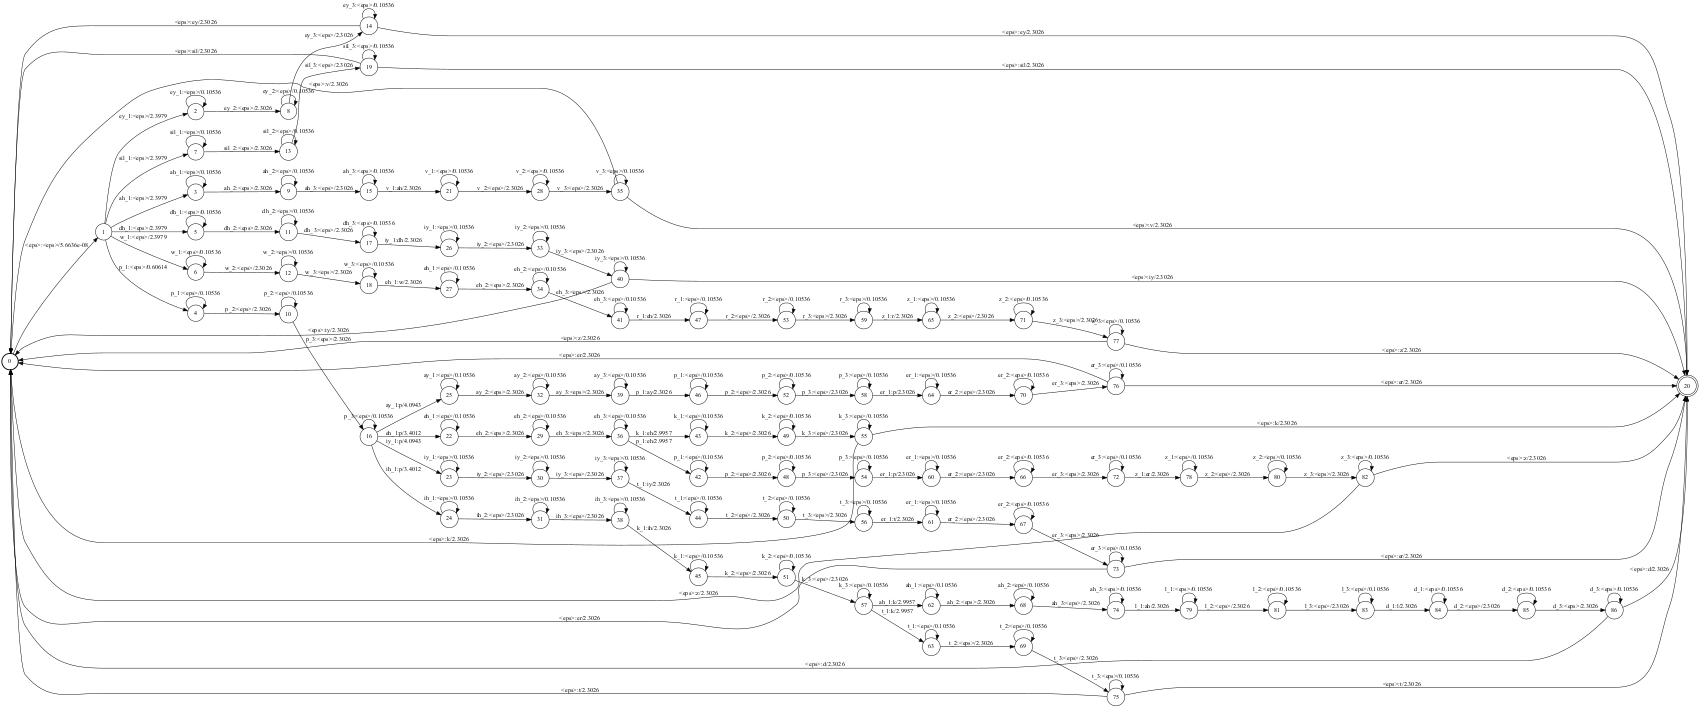

In [10]:
def create_wfst(bigram):
    """ generate a HMM to recognise any single word sequence for words in the lexicon
    
    Args:
        n (int): states per phone HMM

    Returns:
        the constructed WFST
    
    """
    
    BIGRAM_THRESHOLD = 0.1
    
    f = fst.Fst('log')
    n = 3
    f.set_input_symbols(state_table)
    f.set_output_symbols(phone_table)
    # create a single start state
    start_state = f.add_state()
    f.set_start(start_state)

    f_weight = fst.Weight('log', -math.log(1)) #when no silence, set final weight to -log(1)
    start_weight = fst.Weight('log', -math.log(1/11))
    
    first_states = []
    final_states = []
    for word, phones in lex.items():
        current_state = f.add_state()
        first_states.append((current_state, word))
        
        f.add_arc(start_state, fst.Arc(0, 0, start_weight, current_state))
        for phone in phones: 
            current_state = generate_phone_wfst(f, current_state, phone, n)
        # note: new current_state is now set to the final state of the previous phone WFST
        
        f.set_final(current_state)
        
        f.add_arc(current_state, fst.Arc(0, 0, f_weight, start_state))
        
        final_states.append((current_state, word))
        
    #for current_state, current_word in final_states:
        #print(current_word)
        #for next_state, next_word in first_states:
            #if bigram[current_word][next_word] > BIGRAM_THRESHOLD:
                #print(next_word)
                #print(bigram[current_word][next_word])    
                #f.add_arc(current_state, fst.Arc(0, 0, fst.Weight('log', -math.log(bigram[current_word][next_word])), next_state)) 
        
    return f
bigrams = build_bigram_model_backoff(all_transcription)
f = create_wfst(bigrams)
f = fst.determinize(f)
from subprocess import check_call
from IPython.display import Image
f.draw('tmp.dot', portrait=True)
check_call(['dot','-Tpng','-Gdpi=200','tmp.dot','-o','tmp.png'])
Image(filename='tmp.png')

In [8]:
#with open("Task 2 silence test.txt", "w") as file:

with open("Task 4 Bigram with Backoff 0.05 unseen non determinised bigramthresh 0.1 normalised gpt forward and pruning.txt", "w") as file:
    bigram = build_bigram_model_backoff(all_transcription)
    f = create_wfst(bigram)
#     if bigram:
#         comp2 = fst.compose(f, G2)
#         f = fst.determinize(comp2)
#     print(f)
    #f = fst.determinize(f)
    state_count = 0
    arc_count = 0
    for state in f.states():
        state_count += 1
        arc_count += len([arc for arc in f.arcs(state)])

        
    
        
    print(f'State Count: {state_count}, \nArc Count: {arc_count} \n')
    file.write(f"State Count: {state_count}, Arc Count: {arc_count} \n")


    for wav_file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):    # replace path if using your own
                                                                               # audio files

        decoder = MyViterbiDecoder(f, wav_file)

        decode_steps, decode_time = decoder.decode(bigram)
        (state_path, words, backtrace_time) = decoder.backtrace()  # you'll need to modify the backtrace() from Lab 4
                                                   # to return the words along the best path

        transcription = read_transcription(wav_file)
        error_counts = wer.compute_alignment_errors(transcription, words)
        word_count = len(transcription.split())

        word_error_rate = error_counts[0] + error_counts[1] + error_counts[2]

        word_error_rate = (word_error_rate/word_count)*100
        wav_file_name = wav_file.split("/")[-1]

        print(f'File: {wav_file_name}, \nErrors: {error_counts}, \nWER: {word_error_rate}, \nExpected: "{transcription}",\nactual: "{words}", \nSteps Taken: {decode_steps}, \nDecode Time: {decode_time}, \nBacktrace Time: {backtrace_time} \n')
        file.write(f'File: {wav_file_name}, \nErrors: {error_counts}, \nWER: {word_error_rate}, \nExpected: "{transcription}",\nActual: "{words}", \nSteps Taken: {decode_steps}, \nDecode Time: {decode_time}, \nBacktrace Time: {backtrace_time} \n')

print("\nDone")
        # you'll need to accumulate these to produce an overall Word Error Rate

State Count: 120, 
Arc Count: 256 

File: 0000.wav, 
Errors: (3, 1, 2), 
WER: 75.0, 
Expected: "peter piper pickled a peck of picked peppers",
actual: "where's of a of pickled of peck of picked", 
Steps Taken: 758, 
Decode Time: 1.2964821539935656, 
Backtrace Time: 0.0004098530043847859 



KeyboardInterrupt: 

In [ ]:
print("Done")
#f = create_wfst(bigram)
#from subprocess import check_call
#from IPython.display import Image
#f.draw('tmp.dot', portrait=True)
#check_call(['dot','-Tpng','-Gdpi=200','tmp.dot','-o','tmp.png'])
#Image(filename='tmp.png')

In [ ]:
#